In [125]:
from astropy.io import fits
import numpy as np

In [126]:
file = fits.open('../data/uv_test/at2024tvd.fits')
data = file[1].data

In [127]:
file[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                 2790 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
TTYPE1  = 'Frequency bin'      / label for field   1                            
TFORM1  = '1J      '           / data format of field: 4-byte INTEGER           
TTYPE2  = 'indexU  '           / label for field   2                            
TFORM2  = '1I      '           / data format of field: 2-byte INTEGER           
TTYPE3  = 'indexV  '        

In [128]:
data

FITS_rec([(0, 18,  0, 420.6604   , -275.8114   , 86699.3    ),
          (0, 19,  0,  24.46373  ,  -94.33884  , 32877.39   ),
          (0, 20,  0, 145.33069  ,   -2.4174213, 40204.633  ), ...,
          (1,  7, 50,   6.2507386,  -45.22141  ,  1108.3508 ),
          (1,  8, 50, -27.927786 ,  -17.995735 ,   601.1217 ),
          (1,  9, 50,   7.941753 ,  -14.429062 ,   148.72305)],
         dtype=(numpy.record, [('Frequency bin', '>i4'), ('indexU', '>i2'), ('indexV', '>i2'), ('Re', '>f4'), ('Im', '>f4'), ('Weight', '>f4')]))

In [129]:
vis = np.array(data)

In [130]:
vis

array([(0, 18,  0, 420.6604   , -275.8114   , 86699.3    ),
       (0, 19,  0,  24.46373  ,  -94.33884  , 32877.39   ),
       (0, 20,  0, 145.33069  ,   -2.4174213, 40204.633  ), ...,
       (1,  7, 50,   6.2507386,  -45.22141  ,  1108.3508 ),
       (1,  8, 50, -27.927786 ,  -17.995735 ,   601.1217 ),
       (1,  9, 50,   7.941753 ,  -14.429062 ,   148.72305)],
      dtype=(numpy.record, [('Frequency bin', '>i4'), ('indexU', '>i2'), ('indexV', '>i2'), ('Re', '>f4'), ('Im', '>f4'), ('Weight', '>f4')]))

In [131]:
conj_vis = vis.copy()

In [132]:
for i in range(len(conj_vis)):
    tup = conj_vis[i]
    conj_vis[i] = (tup[0], tup[1], -1*tup[2], tup[3], tup[4], tup[5])

In [133]:
conj_vis

array([(0, 18,   0, 420.6604   , -275.8114   , 86699.3    ),
       (0, 19,   0,  24.46373  ,  -94.33884  , 32877.39   ),
       (0, 20,   0, 145.33069  ,   -2.4174213, 40204.633  ), ...,
       (1,  7, -50,   6.2507386,  -45.22141  ,  1108.3508 ),
       (1,  8, -50, -27.927786 ,  -17.995735 ,   601.1217 ),
       (1,  9, -50,   7.941753 ,  -14.429062 ,   148.72305)],
      dtype=(numpy.record, [('Frequency bin', '>i4'), ('indexU', '>i2'), ('indexV', '>i2'), ('Re', '>f4'), ('Im', '>f4'), ('Weight', '>f4')]))

In [134]:
vis = np.concatenate((vis, conj_vis), axis=0)

In [135]:
freq_bin, u, v, Re, Im, w = [], [], [], [], [], []
for row in vis:
    print(row)
    freq_bin_data, u_data, v_data, Re_data, Im_data, w_data = row
    freq_bin.append(int(freq_bin_data))
    u.append(int(u_data))
    v.append(int(v_data))
    Re.append(float(Re_data))
    Im.append(float(Im_data))
    w.append(float(w_data))

(0, 18, 0, 420.6604, -275.8114, 86699.3)
(0, 19, 0, 24.46373, -94.33884, 32877.39)
(0, 20, 0, 145.33069, -2.4174213, 40204.633)
(0, 23, 0, 1.4353743, -33.811626, 1021.2595)
(0, 24, 0, 99.32072, -26.383522, 6776.4473)
(0, 25, 0, 29.976753, 162.44958, 14874.939)
(0, 26, 0, 10.723038, 46.159695, 15547.498)
(0, 27, 0, 7.460951, -6.6807423, 9260.7295)
(0, 28, 0, -19.78506, 146.84334, 9277.295)
(0, 29, 0, 82.82843, 70.987526, 21874.682)
(0, 30, 0, -81.6448, -5.9375324, 22883.09)
(0, 31, 0, 12.161322, 13.729667, 3228.1677)
(0, 32, 0, -151.88356, -101.281075, 16131.986)
(0, 33, 0, 58.52474, 33.172398, 8797.521)
(0, 34, 0, 76.03831, 58.758015, 7779.06)
(0, 35, 0, 212.15347, -100.450676, 9186.948)
(0, 36, 0, 28.168491, -25.467094, 3307.0054)
(0, 37, 0, 23.38693, -50.39192, 5571.5044)
(0, 38, 0, 51.29426, -45.075676, 5567.443)
(0, 39, 0, -1.0430479, 26.21889, 1441.3969)
(0, 40, 0, 0.09654328, -0.87036943, 1.1379021)
(1, 17, 1, 1.3312397, 19.616201, 973.5651)
(1, 18, 1, -116.59431, -177.39987, 910

Text(0, 0.5, 'v (klambda)')

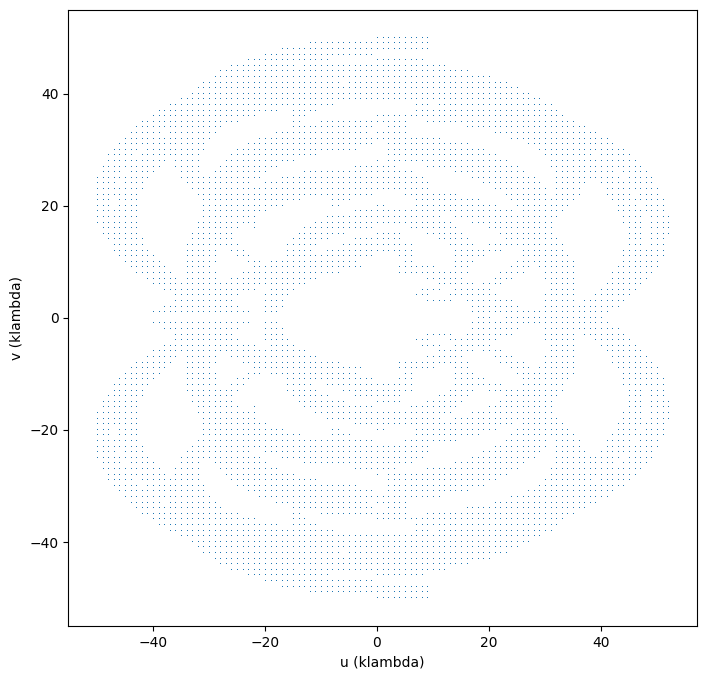

In [136]:
import matplotlib.pyplot as pl
fig=pl.figure(figsize=(15,8))
ax=fig.add_subplot(111)
ax.plot(u,v, ',', alpha=1.0, ms=0.1)
ax.set_aspect(aspect=1.0)
ax.set_xlabel('u (klambda)')
ax.set_ylabel('v (klambda)')